In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pedalboard.pedalboard import load_plugin

from src.dataset.paired_audio_dataset import PairedAudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.style_transfer_vae import StyleTransferVAE

In [2]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "mda Overdrive"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES_PER_SETTING = 500
NUM_SETTINGS = 20
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_style_vae/3kdv9ddi/checkpoints/epoch=820-step=513125.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]
PEAK_NORMALISE = True

In [3]:
def dafx_from_name(dafx_name):
    if dafx_name.lower() == "clean":
        return NullDAFXWrapper()
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [4]:
def get_dataset(dafx):
    dataset = PairedAudioDataset(
        dafx=dafx,
        audio_dir=AUDIO_DIR,
        subset="train",
        input_dirs=DATASETS,
        num_examples_per_epoch=NUM_EXAMPLES_PER_SETTING,
        augmentations={},
        length=131_072,
        effect_input=False,
        effect_output=True,
        dummy_setting=True
    )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

In [5]:
dafx = dafx_from_name(DAFX_NAME)

In [6]:
def get_interpolated_settings(dafx, setting_idx, num_samples=100):
    num_settings = len(dafx.param_names)

    assert(setting_idx <= num_settings)

    settings = []
    for i in np.linspace(0,1, num_samples):
        s = torch.ones(num_settings) * 0.5
        s[setting_idx] = i
        settings.append(s)

    return settings

In [7]:
from src.utils import peak_normalise

def audio_to_spectrogram(signal: torch.Tensor,
                         n_fft: int = 4096,
                         hop_length: int = 2048,
                         window_size: int = 4096,
                         normalise_audio: bool = False):

    bs, _, _ = signal.size()

    if normalise_audio:
        signal = peak_normalise(signal)

    window = torch.hann_window(window_size).to(signal.device)

    X = torch.stft(
        signal.view(bs, -1),
        n_fft=n_fft,
        hop_length=hop_length,
        window=window,
        return_complex=True,
    )

    # Absolute value part
    X_db = torch.pow(X.abs() + 1e-8, 0.3)

    # Normalise spectrogram (0,1)
    X_db_norm = (X_db - X_db.mean()) / X_db.std()

    X_db_norm = X_db_norm.unsqueeze(1).permute(0, 1, 3, 2)

    return X_db_norm

In [8]:
settings_to_apply = get_interpolated_settings(dafx, 1, 10)

In [9]:
settings_to_apply

[tensor([0.5000, 0.0000, 0.5000]),
 tensor([0.5000, 0.1111, 0.5000]),
 tensor([0.5000, 0.2222, 0.5000]),
 tensor([0.5000, 0.3333, 0.5000]),
 tensor([0.5000, 0.4444, 0.5000]),
 tensor([0.5000, 0.5556, 0.5000]),
 tensor([0.5000, 0.6667, 0.5000]),
 tensor([0.5000, 0.7778, 0.5000]),
 tensor([0.5000, 0.8889, 0.5000]),
 tensor([0.5000, 1.0000, 0.5000])]

In [10]:
model = StyleTransferVAE.load_from_checkpoint(CHECKPOINT)
model.eval()
model.to("cuda")

StyleTransferVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mu): Linear(in_features=20640, out_features=4096, bias=True)
  (log_var): Linear(in_features=2064

In [11]:
model.device

device(type='cuda', index=0)

In [12]:
latent_embeddings = dict()

In [13]:
dataset = get_dataset(dafx_from_name('clean'))

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 42699.99it/s]


Loaded 88 files for train = 66.89 hours.


In [14]:
from tqdm import tqdm

for i in range(dafx.get_num_params()):
    setting_name = dafx.idx_to_param_map[i]
    print(f"Interpolating setting: {setting_name}")
    embeddings = []
    settings_to_apply = get_interpolated_settings(dafx, i, NUM_SETTINGS)
    for setting in settings_to_apply:
        print(f"Applying setting: {setting}")
        for batch in tqdm(dataset):
            x, y = batch

            # Apply setting to audio
            y = dafx.apply(y, setting)
            y = y.unsqueeze(0).unsqueeze(0)

            x_s = audio_to_spectrogram(signal=x)
            y_s = audio_to_spectrogram(signal=y)

            X = torch.concat([x_s, y_s], dim=1).to("cuda")

            _, _, _, z = model(X)

            embeddings.append(z.cpu().detach().numpy())

        latent_embeddings[setting_name] = np.array(embeddings)


Interpolating setting: drive
Applying setting: tensor([0.0000, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 73.27it/s] 


Applying setting: tensor([0.0526, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 80.51it/s] 


Applying setting: tensor([0.1053, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 80.78it/s] 


Applying setting: tensor([0.1579, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 79.95it/s] 


Applying setting: tensor([0.2105, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 81.92it/s] 


Applying setting: tensor([0.2632, 0.5000, 0.5000])


100%|██████████| 500/500 [00:05<00:00, 83.58it/s] 


Applying setting: tensor([0.3158, 0.5000, 0.5000])


100%|██████████| 500/500 [00:05<00:00, 85.89it/s] 


Applying setting: tensor([0.3684, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 80.18it/s] 


Applying setting: tensor([0.4211, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 74.10it/s] 


Applying setting: tensor([0.4737, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 79.55it/s] 


Applying setting: tensor([0.5263, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 76.35it/s] 


Applying setting: tensor([0.5789, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 77.65it/s] 


Applying setting: tensor([0.6316, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 74.30it/s] 


Applying setting: tensor([0.6842, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 73.82it/s] 


Applying setting: tensor([0.7368, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 75.20it/s] 


Applying setting: tensor([0.7895, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 77.70it/s] 


Applying setting: tensor([0.8421, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 78.05it/s] 


Applying setting: tensor([0.8947, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 80.08it/s] 


Applying setting: tensor([0.9474, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 75.11it/s] 


Applying setting: tensor([1.0000, 0.5000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 77.11it/s] 


Interpolating setting: muffle
Applying setting: tensor([0.5000, 0.0000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 76.61it/s] 


Applying setting: tensor([0.5000, 0.0526, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 76.78it/s] 


Applying setting: tensor([0.5000, 0.1053, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 76.82it/s] 


Applying setting: tensor([0.5000, 0.1579, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 76.20it/s] 


Applying setting: tensor([0.5000, 0.2105, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 77.98it/s] 


Applying setting: tensor([0.5000, 0.2632, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 75.20it/s] 


Applying setting: tensor([0.5000, 0.3158, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 76.98it/s] 


Applying setting: tensor([0.5000, 0.3684, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 77.98it/s] 


Applying setting: tensor([0.5000, 0.4211, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 77.63it/s] 


Applying setting: tensor([0.5000, 0.4737, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 78.50it/s] 


Applying setting: tensor([0.5000, 0.5263, 0.5000])


100%|██████████| 500/500 [00:07<00:00, 70.74it/s] 


Applying setting: tensor([0.5000, 0.5789, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 76.07it/s] 


Applying setting: tensor([0.5000, 0.6316, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 77.64it/s] 


Applying setting: tensor([0.5000, 0.6842, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 77.55it/s] 


Applying setting: tensor([0.5000, 0.7368, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 76.88it/s] 


Applying setting: tensor([0.5000, 0.7895, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 77.38it/s] 


Applying setting: tensor([0.5000, 0.8421, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 76.91it/s] 


Applying setting: tensor([0.5000, 0.8947, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 77.13it/s] 


Applying setting: tensor([0.5000, 0.9474, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 76.29it/s] 


Applying setting: tensor([0.5000, 1.0000, 0.5000])


100%|██████████| 500/500 [00:06<00:00, 75.90it/s] 


Interpolating setting: output_db
Applying setting: tensor([0.5000, 0.5000, 0.0000])


100%|██████████| 500/500 [00:06<00:00, 75.03it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.0526])


100%|██████████| 500/500 [00:06<00:00, 78.44it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.1053])


100%|██████████| 500/500 [00:06<00:00, 78.32it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.1579])


100%|██████████| 500/500 [00:06<00:00, 81.64it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.2105])


100%|██████████| 500/500 [00:06<00:00, 79.12it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.2632])


100%|██████████| 500/500 [00:06<00:00, 76.38it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.3158])


100%|██████████| 500/500 [00:06<00:00, 80.64it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.3684])


100%|██████████| 500/500 [00:06<00:00, 82.90it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.4211])


100%|██████████| 500/500 [00:06<00:00, 80.91it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.4737])


100%|██████████| 500/500 [00:06<00:00, 81.34it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.5263])


100%|██████████| 500/500 [00:06<00:00, 80.00it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.5789])


100%|██████████| 500/500 [00:06<00:00, 80.85it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.6316])


100%|██████████| 500/500 [00:06<00:00, 78.36it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.6842])


100%|██████████| 500/500 [00:06<00:00, 79.72it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.7368])


100%|██████████| 500/500 [00:06<00:00, 79.84it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.7895])


100%|██████████| 500/500 [00:06<00:00, 80.42it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.8421])


100%|██████████| 500/500 [00:06<00:00, 82.70it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.8947])


100%|██████████| 500/500 [00:06<00:00, 81.45it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.9474])


100%|██████████| 500/500 [00:06<00:00, 81.79it/s] 


Applying setting: tensor([0.5000, 0.5000, 1.0000])


100%|██████████| 500/500 [00:06<00:00, 77.46it/s] 


In [15]:
data = np.concatenate([v for v in latent_embeddings.values()]).squeeze()

In [16]:
data.shape

(30000, 4096)

In [17]:
import umap

In [18]:
reducer = umap.UMAP().fit(data)

In [19]:
import seaborn as sns

sns.set()

In [20]:
EXPERIMENT_NAME = f"{CHECKPOINT_ID}_{DAFX_NAME.split()[-1]}_{NUM_SETTINGS}settings"

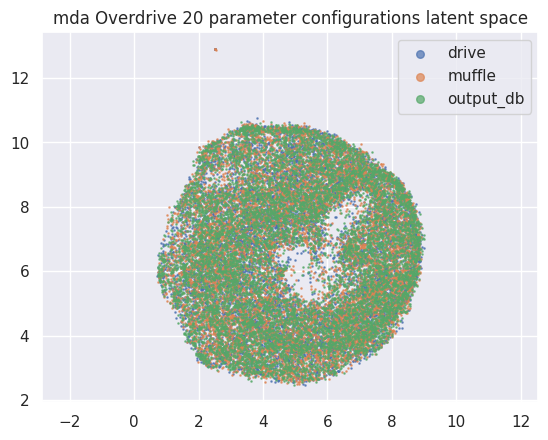

In [21]:
for fx, X in latent_embeddings.items():
    embeds = reducer.transform(X.squeeze())
    plt.scatter(x=embeds[:,0], y=embeds[:,1], label=fx, alpha=0.7, s=0.8)

plt.gca().set_aspect('equal', 'datalim')
plt.title(f"{DAFX_NAME} {NUM_SETTINGS} parameter configurations latent space")

lgnd = plt.legend()
for i in range(len(latent_embeddings.keys())):
    lgnd.legendHandles[i]._sizes = [30]

figname = f"./figures/indiv_param_normalise/{EXPERIMENT_NAME}_latent_embeddings_normalised_audio.svg" if PEAK_NORMALISE else f"./figures/indiv_param_normalise/{EXPERIMENT_NAME}_latent_embeddings.svg"
plt.savefig(figname)

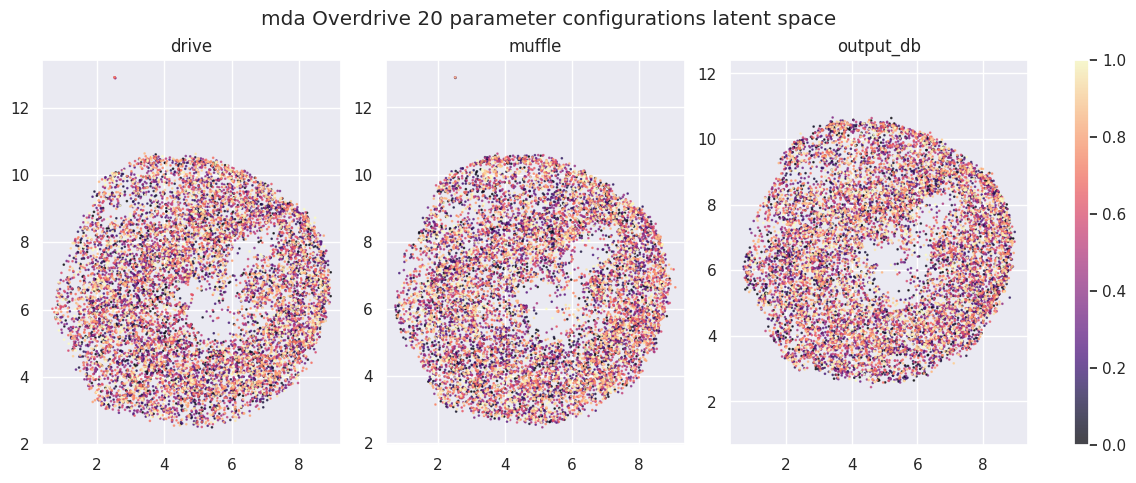

In [22]:
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(4.5*dafx.get_num_params(), 5))
gs = gridspec.GridSpec(1, dafx.get_num_params() + 1, width_ratios=[1]*dafx.get_num_params() + [0.05])

for i in range(dafx.get_num_params()):
    param_name = dafx.idx_to_param_map[i]
    X = latent_embeddings[param_name]

    embeds = reducer.transform(X.squeeze())
    settings_to_apply = get_interpolated_settings(dafx, i, NUM_SETTINGS)
    colours = np.array([np.array([setting[i]]*NUM_EXAMPLES_PER_SETTING) for setting in settings_to_apply])

    ax = fig.add_subplot(gs[0, i])
    sc = ax.scatter(x=embeds[:,0], y=embeds[:,1], alpha=0.7, s=0.8, c=colours, vmin=0, vmax=1, cmap='magma')

    ax.set_title(param_name)
    ax.set_aspect('equal', 'datalim')

plt.suptitle(f"{DAFX_NAME} {NUM_SETTINGS} parameter configurations latent space")

cax = fig.add_subplot(gs[0, -1])
plt.colorbar(sc, cax=cax)

fig.subplots_adjust(right=0.9)

figname = f"./figures/indiv_param_normalise/{EXPERIMENT_NAME}_latent_embeddings_cmap_normalised_audio.svg" if PEAK_NORMALISE else f"./figures/indiv_param_normalise/{EXPERIMENT_NAME}_latent_embeddings_cmap.svg"
plt.savefig(figname)